## Processing results from mapping publically available marine metagenomes to T.NPSG genome

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import glob
from mpl_toolkits.basemap import Basemap
import pypalettes
from pypalettes import load_cmap
from pypalettes import get_hex
from pycirclize import Circos
from pycirclize.parser import Gff, Genbank
from pycirclize.utils import load_prokaryote_example_file, ColorCycler
from matplotlib.patches import Patch
from matplotlib.patches import Circle
import matplotlib.lines as mlines

In [3]:
sns.set_theme(context = 'paper',style='whitegrid',font_scale=2)

## Choose subset of Tara Oceans metagenomes to map to T.NPSG - all metagenomes with diazotrophic tricho and a random subset of ones without based on Delmont 2021 (https://pmc.ncbi.nlm.nih.gov/articles/PMC8609553/)

In [4]:
#Read in tara metadata from Delmont 2021 to choose which samples to use for mapping
tara_tricho = pd.read_csv('mapping_files/tricho_abundance_tara.csv',index_col=0)
tricho_present = tara_tricho[(tara_tricho[['Trichodesmium thiebautii Atlantic-pop',
       'Trichodesmium thiebautii Indian-pop', 'Trichodesmium erythraeum']].sum(axis=1) > 0)]
absent = tara_tricho.loc[~tara_tricho.index.isin(tricho_present)]

In [5]:
print("Number of samples containing diazotrophic tricho: "+str(len(tricho_present.index.values)))
print("Number of samples NOT containing diazotrophic tricho: "+str(len(absent.index.values)))

Number of samples containing diazotrophic tricho: 94
Number of samples NOT containing diazotrophic tricho: 937


In [6]:
#read in file with metagenome sample name/ENA correspondence
tara_ena = pd.read_csv('mapping_files/tara_metadata_ena.csv', index_col=0)

In [7]:
#Get ENAs for all samples with tricho plus a random selection of samples without tricho
all_ena = tara_ena.loc[list(tricho_present.index.values) + list(absent.sample(93).index.values)]
#separate samples with multiple vs single numbers - need to be processed differently
all_ena_single = all_ena[(~all_ena['ERR'].str.contains(','))]
all_ena_multiple = all_ena[(all_ena['ERR'].str.count(',') >= 1)]

In [8]:
#all_ena_single['ERR'].to_csv('single_SRA_samples.tab',sep='\t',header=False,index=False)
#all_ena_multiple['ERR'].to_csv('multiple_SRA_samples.tab',sep='\t',header=False,index=False)

## Process output from bwa mapping of tara metagenomes

In [9]:
#Read in tara metadata
sample_meta = pd.read_csv('mapping_files/tara_metadata_sample.csv',index_col=0)
station_meta = pd.read_csv('mapping_files/tara_metadata_station.csv')

In [10]:
sample_meta.groupby('Size_Categorie').value_counts(['Filter_Size'])

Size_Categorie  Filter_Size
Size_01         0.8-5µm        160
                0.22-3µm       101
                0.2-1.6µm       32
Size_02         5-20µm          97
                3-20µm          33
Size_03         20-180µm       188
                20-200µm         4
Size_04         180-2000µm     194
Size_All        0.8-2000µm     130
Name: count, dtype: int64

In [11]:
#read in coverage information from each file resulting from mapping tara data to virus genome + compiled, dereplicated MAGs
to_cat = []
for i in glob.glob('/ocean/projects/ees230009p/agomez3/tricho_virus_mapping/tara/*_coverage.tab'):
    sample = i.split('/')[7].split('_coverage')[0]
    infile = pd.read_csv(i,sep='\t')
    scale = (infile['numreads']/(infile['endpos']/1000)).sum()/1000000
    virus = infile[infile['#rname'] == 'tricho_phage_NPSG.2']
    if len(virus.index.values) > 0:
        virus = virus.iloc[0]
        virus.loc['CPM'] = virus['numreads']/(virus['endpos']/1000)/scale
        to_cat.append(virus.rename(sample))
    else: 
        print(i)
tara_coverage = pd.concat(to_cat,axis=1).T
tara_coverage

,#rname,startpos,endpos,numreads,covbases,coverage,meandepth,meanbaseq,meanmapq,CPM
ERR599049,tricho_phage_NPSG.2,1,149200,0,0,0.0,0.0,0.0,0.0,0.0
ERR868419,tricho_phage_NPSG.2,1,149200,0,0,0.0,0.0,0.0,0.0,0.0
ERR1726559,tricho_phage_NPSG.2,1,149200,0,0,0.0,0.0,0.0,0.0,0.0
ERR4691598,tricho_phage_NPSG.2,1,149200,0,0,0.0,0.0,0.0,0.0,0.0
ERR599098,tricho_phage_NPSG.2,1,149200,0,0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
ERR599081,tricho_phage_NPSG.2,1,149200,0,0,0.0,0.0,0.0,0.0,0.0
ERR868460,tricho_phage_NPSG.2,1,149200,0,0,0.0,0.0,0.0,0.0,0.0
ERR1726673,tricho_phage_NPSG.2,1,149200,0,0,0.0,0.0,0.0,0.0,0.0
ERR1726974,tricho_phage_NPSG.2,1,149200,0,0,0.0,0.0,0.0,0.0,0.0


In [12]:
#Combine sample metadata with coverage output, fix longitude values for plotting
tara_ena['ERR_split'] = tara_ena['ERR'].str.split(',')
all_ena = tara_ena.explode('ERR_split').reset_index().set_index('ERR_split')
new_ena=all_ena.loc[tara_coverage.index.values]
metadata_by_err = pd.merge(left = new_ena, right=sample_meta,left_on='Metagenome',right_index=True,how='left')
metadata_by_err.loc[:,'Metagenome'] =  metadata_by_err['Metagenome'].replace('81DCM01SSUU11','81DCM0SSUU11')
metadata_by_err.loc[:,'station'] = metadata_by_err['Metagenome'].str[:-7]
all_meta_by_err = pd.merge(left=metadata_by_err.reset_index(), right=station_meta,left_on='station',right_on='Station',how='left').set_index('ERR_split')
tara_cov_meta = pd.merge(left=tara_coverage,right=all_meta_by_err,left_index=True,right_index=True,how='left')
tara_cov_meta.loc[:,'logCPM'] = np.log10(tara_cov_meta['CPM'].astype(float))
#Convert Lat and Long for plotting
tara_cov_meta.loc[:,'Longitude_plot'] = tara_cov_meta['Longitude'].apply(lambda x: (0 if (x > 0) else 360) + x)
tara_cov_meta.loc[:,'Region'] = tara_cov_meta['Region'].replace('Red_Sea','Red Sea')
tara_cov_meta[(tara_cov_meta['Region'] == 'Pacific') & (tara_cov_meta['Latitude'].astype(float) >= 0)] = tara_cov_meta[(tara_cov_meta['Region'] == 'Pacific') & (tara_cov_meta['Latitude'].astype(float) >= 0)].replace('Pacific','North Pacific')
tara_cov_meta[(tara_cov_meta['Region'] == 'Pacific') & (tara_cov_meta['Latitude'].astype(float) < 0)] = tara_cov_meta[(tara_cov_meta['Region'] == 'Pacific') & (tara_cov_meta['Latitude'].astype(float) < 0)].replace('Pacific','South Pacific')
tara_cov_meta[(tara_cov_meta['Region'] == 'Atlantic') & (tara_cov_meta['Latitude'].astype(float) >= 0)] = tara_cov_meta[(tara_cov_meta['Region'] == 'Atlantic') & (tara_cov_meta['Latitude'].astype(float) >= 0)].replace('Atlantic','North Atlantic')
tara_cov_meta[(tara_cov_meta['Region'] == 'Atlantic') & (tara_cov_meta['Latitude'].astype(float) < 0)] = tara_cov_meta[(tara_cov_meta['Region'] == 'Atlantic') & (tara_cov_meta['Latitude'].astype(float) < 0)].replace('Atlantic','South Atlantic')

/jet/home/agomez3/.local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [13]:
#Which samples have tricho?
tara_cov_tricho = pd.merge(left=tara_cov_meta.reset_index(),right=tara_tricho,left_on='Metagenome',right_index=True,how='left')
tara_cov_tricho.loc[:,'tricho_present'] = tara_cov_tricho[['Trichodesmium thiebautii Atlantic-pop','Trichodesmium thiebautii Indian-pop','Trichodesmium erythraeum']].sum(axis=1)
tara_cov_meta.loc[:,'tricho_present'] = np.where(tara_cov_tricho['tricho_present'] > 0,'Tricho present','No Tricho')

## Read in mapping results from picked tricho colonies


In [14]:
sample_info = pd.read_csv('mapping_files/FYP_Tricho_Metadata.csv').drop(['Unnamed: 9'],axis=1).drop([32,33])
sample_info = sample_info.set_index('Sample_Accession')
sample_info.index = ['NP01', 'SRR6490001', 'SRR6490002', 'SRR6490003', 'SRR6490004',
       'SRR6490005', 'SRR6490006', 'SRR19658999', 'SRR19658998', 'SRR19658995',
       'SRR19658989', 'SRR19658990', 'SRR19658991', 'SRR19658992',
       'SRR19658996', 'SRR19658997', 'SRR19658993', 'SRR19658994',
       'SRR7822613', 'SRR7822620', 'SRR7822621', 'SRR26283904', 'SRR26283905',
       'SRR26283956', 'SRR26283955', 'SRR17940154', 'SRR17940155',
       'SRR17940156', 'SRR5134611', 'SRR5134580', 'SRR14246929', 'S281']
sample_info.loc['FischkornScope22March16_TAGCTT'] = pd.Series({'Region':'North Pacific','Sample ID':'FS16','Source':'Unpublished Dyhrman lab data','Latitude':'24.413ºN','Longitude':'156.312ºW','Collection Date':'Aug-15','size Gb':'20','bases':'NA'})
sample_info.loc['7_7_17_slick_S282'] = pd.Series({'Region':'North Pacific','Sample ID':'slick','Source':'Unpublished Dyhrman lab data','Latitude':'24.97ºN','Longitude':'158.45ºW','Collection Date':'Jul-17','size Gb':'7.9','bases':'NA'})

In [15]:
#read in coverage information from each file resulting from mapping colony data to phage genome + compiled, dereplicated MAGs
to_cat = []
for i in glob.glob('/ocean/projects/ees230009p/agomez3/tricho_virus_mapping/*_coverage.tab'):
    sample = i.split('/')[6].split('_coverage')[0]
    infile = pd.read_csv(i,sep='\t')
    scale = (infile['numreads']/(infile['endpos']/1000)).sum()/1000000
    virus = infile[infile['#rname'] == 'tricho_phage_NPSG.2']
    if len(virus.index.values) > 0:
        virus = virus.iloc[0]
        virus.loc['CPM'] = virus['numreads']/(virus['endpos']/1000)/scale
        to_cat.append(virus.rename(sample))
    else: 
        print(i)

/ocean/projects/ees230009p/agomez3/tricho_virus_mapping/SRR26283956_coverage.tab


In [17]:
colony_cov = pd.concat(to_cat,axis=1).T
colony_cov_meta = pd.merge(left=colony_cov,right=sample_info,left_index=True,right_index=True,how='left')

In [18]:
#Unify column names from Tara and colony results, combine into one dataframe
colony_cov_meta.loc[:,'Latitude'] = colony_cov_meta['Latitude'].apply(lambda x: float(x[:-2]) * (1 if 'N' in x else -1))
colony_cov_meta.loc[:,'Longitude_plot'] = colony_cov_meta['Longitude'].apply(lambda x: (0 if 'E' in x else 360) + (float(x[:-2])* (1 if 'E' in x else -1)))
colony_cov_meta.loc[:,'Longitude'] = colony_cov_meta['Longitude'].apply(lambda x: float(x[:-2]) * (1 if 'N' in x else -1))
colony_cov_meta.loc[:,'Size_Categorie'] = 'colony'
colony_cov_meta.loc[:,'Source'] = 'Picked Colony'
colony_cov_meta.loc[:,'Metagenome'] = 'NA'
colony_cov_meta.loc[:,'depth'] = 'SUR'
colony_cov_meta.loc[:,'tricho_present'] = 'Picked Colony'
colony_cov_meta.loc[:,'station'] = np.nan
tara_cov_meta.loc[:,'Source'] = 'Tara'
tara_cov_meta.loc[:,'depth'] = tara_cov_meta['station'].str[-3:]
all_cov_meta = pd.concat([tara_cov_meta[['numreads', 'covbases', 'coverage','meandepth', 'meanbaseq', 'meanmapq', 'CPM', 'Region','Source', 'Latitude', 'Longitude','Longitude_plot','Size_Categorie','station','Metagenome','depth','tricho_present']],colony_cov_meta[['numreads', 'covbases', 'coverage','meandepth', 'meanbaseq', 'meanmapq', 'CPM', 'Region','Source', 'Latitude', 'Longitude','Longitude_plot','Size_Categorie','station','Metagenome','depth','tricho_present']]])
all_cov_meta['CPM'] = all_cov_meta['CPM'].replace(0,0.01)
all_cov_meta.loc[:,'logCPM'] = np.log10(all_cov_meta['CPM'].astype(float))
all_cov_meta['depth'] = all_cov_meta['depth'].str.replace('CM0','DCM')

/var/tmp/ipykernel_2451/2235223717.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_cov_meta['CPM'] = all_cov_meta['CPM'].replace(0,0.01)


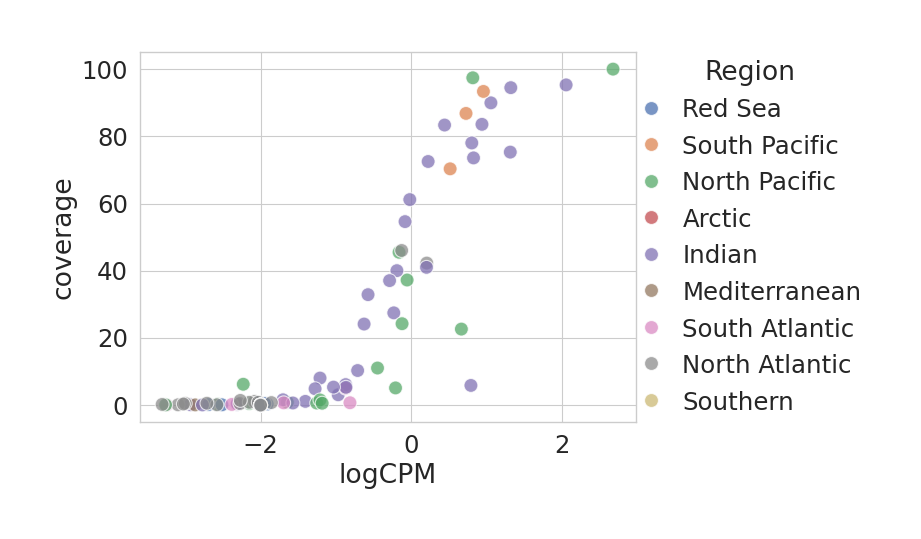

In [19]:
g = sns.scatterplot(data=all_cov_meta,x='logCPM',y='coverage',hue='Region',s=100,alpha=0.75)
sns.move_legend(g,'center right',bbox_to_anchor=(1.5,.5))
#plt.savefig('output_figures/supp_fig_mappingcov_v_cpm.svg',transparent=True,bbox_inches='tight')
plt.show()

In [20]:
#Set coverage cutoff for phage presence at 20, save dataframe
all_cov_meta['phage_present'] = np.where(all_cov_meta['coverage'] > 20, True, False)
all_cov_meta[['numreads', 'covbases', 'coverage','meandepth', 'meanbaseq', 'meanmapq', 'CPM', 'Region','Source', 'Latitude', 'Longitude','Size_Categorie','station','Metagenome','depth','tricho_present','phage_present']].to_csv('output_tables/ST13_metagenome_coverage_with_metadata.csv')

## Plot map with T.NPSG positive metagenomes

In [21]:
all_cov_meta

,numreads,covbases,coverage,meandepth,meanbaseq,meanmapq,CPM,Region,Source,Latitude,Longitude,Longitude_plot,Size_Categorie,station,Metagenome,depth,tricho_present,logCPM,phage_present
ERR599049,0,0,0.0,0.0,0.0,0.0,0.010000,Red Sea,Tara,22.025,38.2333,38.2333,Size_01,33SUR,33SUR0CCII11,SUR,No Tricho,-2.000000,False
ERR868419,0,0,0.0,0.0,0.0,0.0,0.010000,South Pacific,Tara,-8.9971,-139.1963,220.8037,Size_01,122DCM,122DCM1GGMM11,DCM,No Tricho,-2.000000,False
ERR1726559,0,0,0.0,0.0,0.0,0.0,0.010000,North Pacific,Tara,31.5213,-158.9958,201.0042,Size_02,132SUR,132SUR1MMQQ11,SUR,Tricho present,-2.000000,False
ERR4691598,0,0,0.0,0.0,0.0,0.0,0.010000,Arctic,Tara,67.1675,0.2177,0.2177,Size_02,158DCM,158DCM1KKQQ11,DCM,No Tricho,-2.000000,False
ERR599098,0,0,0.0,0.0,0.0,0.0,0.010000,Indian,Tara,-16.957,53.9801,53.9801,Size_01,52SUR,52SUR0CCII11,SUR,No Tricho,-2.000000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR6490005,28,1126,0.754692,0.015731,36.8,55.1,0.013913,North Atlantic,Picked Colony,11.86,-59.44,300.5600,colony,NaN,NA,SUR,Picked Colony,-1.856582,False
SRR19658989,8,498,0.33378,0.006528,36.6,52.8,0.000944,North Atlantic,Picked Colony,7.5,-48.5,311.5000,colony,NaN,NA,SUR,Picked Colony,-3.025217,False
SRR6490006,0,0,0.0,0.0,0.0,0.0,0.010000,North Atlantic,Picked Colony,9.9,-58.49,301.5100,colony,NaN,NA,SUR,Picked Colony,-2.000000,False
SRR19658991,0,0,0.0,0.0,0.0,0.0,0.010000,North Atlantic,Picked Colony,5.0,-44.3,315.7000,colony,NaN,NA,SUR,Picked Colony,-2.000000,False


In [22]:
hex_colors2 = load_cmap("qMSOBuWarm").hex
region_palette = {'Indian':hex_colors2[0],'North Pacific':hex_colors2[1],'South Pacific':hex_colors2[4],'North Atlantic':hex_colors2[6],'npsg_og':'#A37903FF'}
depth_palette = {'SUR': '#FDC718FF','DCM':'#3E938BFF'}
tricho_palette = {'Tricho present':'#548150FF','No Tricho':'#682C37FF','Picked Colony':'#80784AFF'}
marker_dict = {False:'X',True:'o'}

In [23]:
all_cov_meta.loc['7_7_17_slick_S282','Region'] = 'npsg_og'
all_cov_meta.loc['FischkornScope22March16_TAGCTT','Region'] = 'npsg_og'

<>:19: SyntaxWarning: invalid escape sequence '\i'
<>:19: SyntaxWarning: invalid escape sequence '\i'
/var/tmp/ipykernel_2451/2016688570.py:19: SyntaxWarning: invalid escape sequence '\i'
  fraction = mlines.Line2D([], [], marker='None', linestyle='None',label='$\it{Trichodesmium}$ presence')


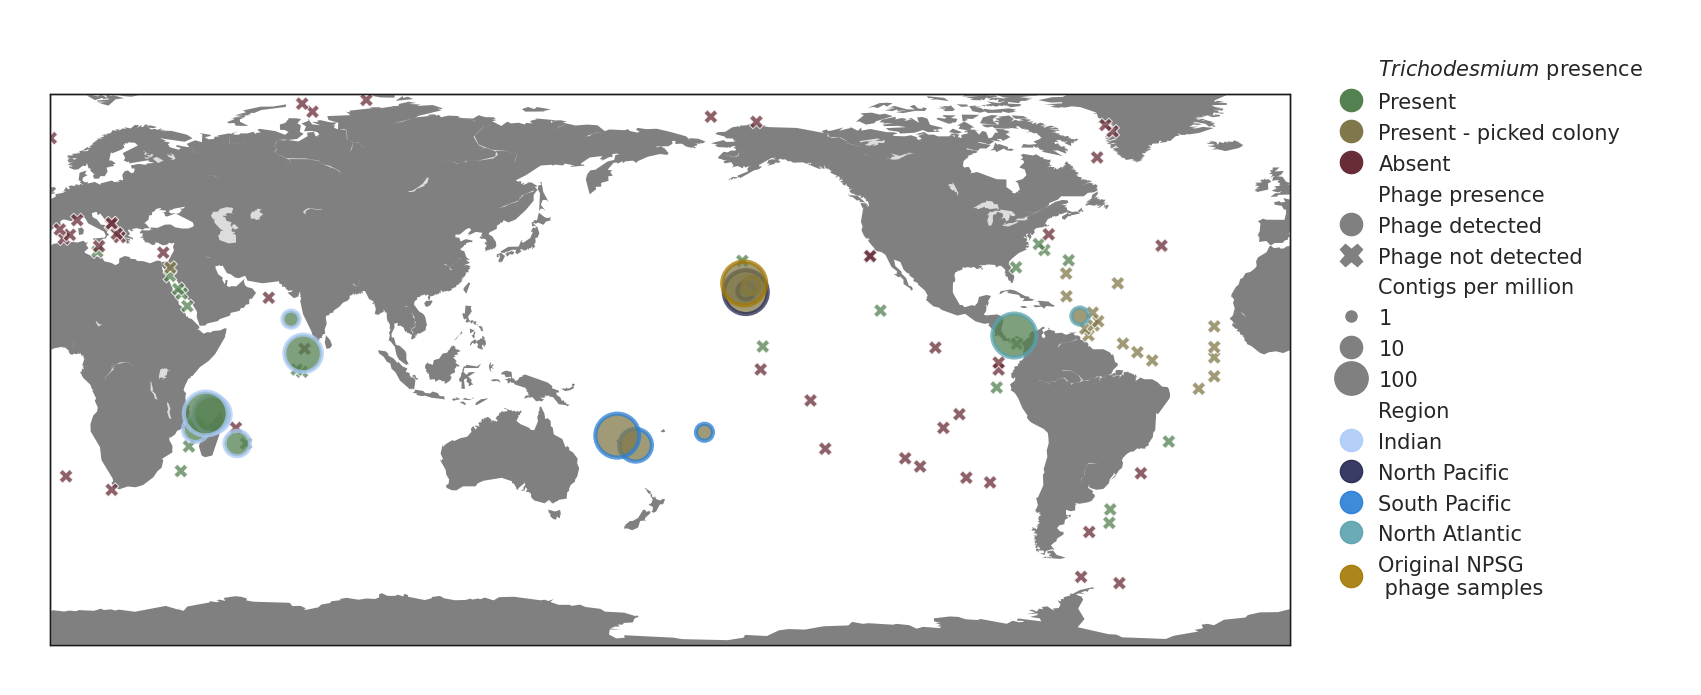

In [29]:
plt.close('all')
fig, ax = plt.subplots(figsize=(16,12))
# llcrnrlat,llcrnrlon,urcrnrlat,urcrnrlon
# are the lat/lon values of the lower left and upper right corners
# of the map.
# resolution = 'c' means use crude resolution coastlines.
m = Basemap(projection='cyl',llcrnrlat=-80,urcrnrlat=80,\
            llcrnrlon=0,urcrnrlon=360,resolution='c',ax=ax)
#m.drawcoastlines(color='grey')
m.fillcontinents(color='grey',lake_color='gainsboro')
m.drawmapboundary(fill_color='white') 
#plt.title("Equidistant Cylindrical Projection")
# Add a point per position
max_cov = all_cov_meta.loc[all_cov_meta.groupby(['Latitude','Longitude'])['coverage'].idxmax().values]
sns.scatterplot(data=max_cov[~max_cov['phage_present']],x='Longitude_plot',y='Latitude',ax=ax,s=100,alpha=.75,marker='X',hue='tricho_present',palette=tricho_palette)
for i in max_cov[max_cov['phage_present']]['Region'].unique():
    sns.scatterplot(data=max_cov[(max_cov['Region'] == i) & max_cov['phage_present']],x='Longitude_plot',y='Latitude',size='logCPM',marker='o',ax=ax,hue='tricho_present',palette=tricho_palette,edgecolor=region_palette[i],linewidth=3,sizes=(150, 1000),alpha=0.75)

fraction = mlines.Line2D([], [], marker='None', linestyle='None',label='$\it{Trichodesmium}$ presence')
size1 = mlines.Line2D([], [], color='#548150FF', marker='o', linestyle='None',markersize=16, label='Present')
size2 = mlines.Line2D([], [], color='#80784AFF', marker='o', linestyle='None', markersize=16, label='Present - picked colony')
size3 = mlines.Line2D([], [], color='#682C37FF', marker='o', linestyle='None',markersize=16, label='Absent')
location = mlines.Line2D([], [], marker='None', linestyle='None',label='Phage presence')
phage1 = mlines.Line2D([], [], color='gray', marker='o', linestyle='None',markersize=16, label='Phage detected')
phage2 = mlines.Line2D([], [], color='gray', marker='X', linestyle='None',markersize=16, label='Phage not detected')
#phage3 = mlines.Line2D([], [], color='black', marker='*', linestyle='None',markersize=16, label='Phage detected, \n no CPM calculated')
cpm = mlines.Line2D([], [], marker='None', linestyle='None', label='Contigs per million')
cpm1 =  mlines.Line2D([], [], color='grey', marker='o', linestyle='None',markersize=8, label='1')
cpm2 =  mlines.Line2D([], [], color='grey', marker='o', linestyle='None',markersize=16, label='10')
cpm3 =  mlines.Line2D([], [], color='grey', marker='o', linestyle='None',markersize=24, label='100')
region =  mlines.Line2D([], [], marker='None', linestyle='None', label='Region')
reg1 = mlines.Line2D([], [], color=region_palette['Indian'], marker='o',linestyle='None',markersize=16, label='Indian',alpha=0.9)
reg2 = mlines.Line2D([], [], color=region_palette['North Pacific'], marker='o',linestyle='None',markersize=16, label='North Pacific',alpha=0.9)
reg3 =  mlines.Line2D([], [], color=region_palette['South Pacific'], marker='o',linestyle='None',markersize=16, label='South Pacific',alpha=0.9)
reg4 =  mlines.Line2D([], [], color=region_palette['North Atlantic'], marker='o',linestyle='None',markersize=16, label='North Atlantic',alpha=0.9)
reg5 =  mlines.Line2D([], [], color=region_palette['npsg_og'], marker='o',linestyle='None',markersize=16, label='Original NPSG \n phage samples',alpha=0.9)
plt.legend(handles=[fraction,size1,size2,size3,location,phage1,phage2,cpm,cpm1,cpm2,cpm3,region,reg1,reg2,reg3,reg4,reg5],bbox_to_anchor=(1.3,1.1),loc='upper right', fontsize=15)
plt.savefig('output_figures/fig4a_global_mapping.svg',transparent=True,bbox_inches='tight')
plt.show()


In [24]:
#Look at phage presence/absence in the context of tricho species presence/absence
tara_cov_tricho.loc[:,'tta_present'] = np.where(tara_cov_tricho['Trichodesmium thiebautii Atlantic-pop'] > 0, True, False)
tara_cov_tricho.loc[:,'ttp_present'] = np.where(tara_cov_tricho['Trichodesmium thiebautii Indian-pop'] > 0, True, False)
tara_cov_tricho.loc[:,'te_present'] = np.where(tara_cov_tricho['Trichodesmium erythraeum'] > 0, True, False)
tara_cov_tricho.loc[:,'tm_present'] = np.where(tara_cov_tricho['Trichodesmium miru'] > 0, True, False)
tara_cov_tricho.loc[:,'tn_present'] = np.where(tara_cov_tricho['Trichodesmium nobis'] > 0, True, False)
tara_cov_tricho.loc[:,'tricho_present'] = np.where(tara_cov_tricho[[ 'tta_present',
       'ttp_present', 'te_present', 'tm_present', 'tn_present']].sum(axis=1), True, False)

/var/tmp/ipykernel_5278/1272240394.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False  True False False  True  True  True  True  True  True False
  True  True False  True  True  True  True  True  True  True False  True
  True False  True  True  True  True  True  True  True False  True False
  True  True  True False False False  True  True  True False False False
 False  True  True  True False  True  True  True  True False  True  True
  True  True  True  True  True  True  True  True  True  True False  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False  True  True  True  True
  True  True  True  True  True  True  True  True  True False  True False
  True  True  True  True  True  True False  True  True False  True False
  True False  True  True False  True  True  True  True  True  True  True
  True  True  True  True  True  True  

<>:3: SyntaxWarning: invalid escape sequence '\i'
<>:3: SyntaxWarning: invalid escape sequence '\i'
/var/tmp/ipykernel_5278/1221574486.py:3: SyntaxWarning: invalid escape sequence '\i'
  plt.xlabel('$\it{Trichodesmium}$ present')
/jet/home/agomez3/.local/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 39.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/jet/home/agomez3/.local/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/jet/home/agomez3/.local/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 55.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/jet/home/agomez3/.local/lib/python3.12/site-packages/seaborn/cat

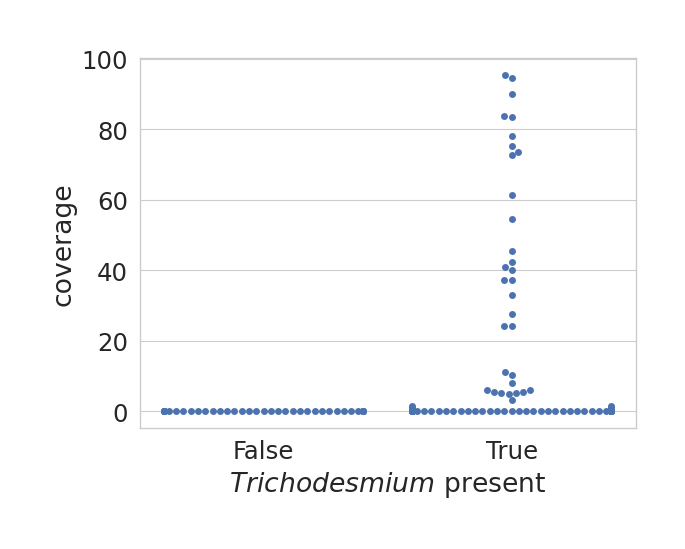

In [25]:
sns.swarmplot(data=tara_cov_tricho, x="tricho_present", y="coverage")
#plt.savefig('output_figures/supp_fig_tricho_phage_presence.svg',transparent=True,bbox_inches='tight')
plt.xlabel('$\it{Trichodesmium}$ present')
plt.show()

/jet/home/agomez3/.local/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 39.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/jet/home/agomez3/.local/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 38.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/jet/home/agomez3/.local/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 60.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/jet/home/agomez3/.local/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 75.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/jet/home/agomez3/.local/lib/python3.12/site-packages/seabor

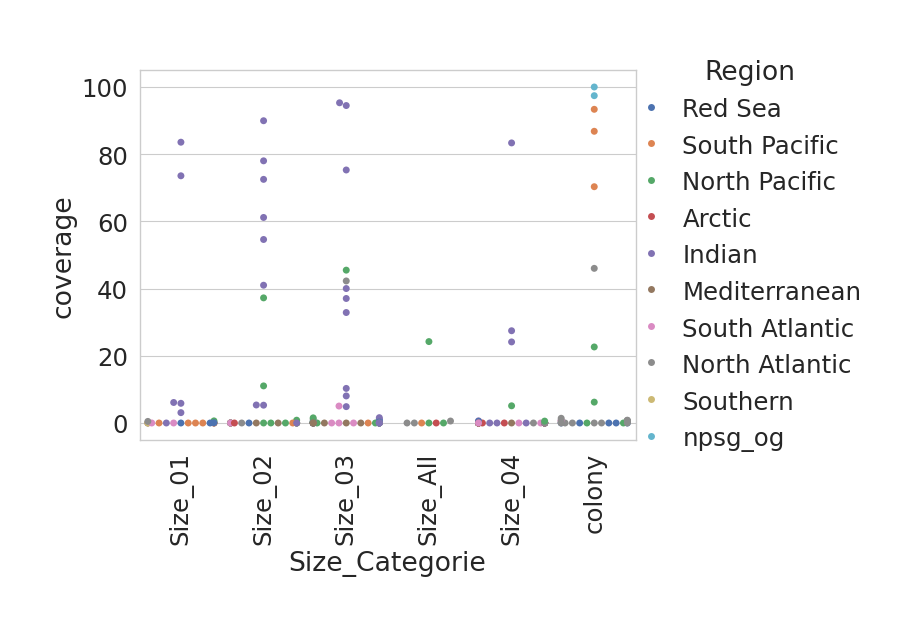

In [26]:
g = sns.swarmplot(data = all_cov_meta, y='coverage',x='Size_Categorie',hue='Region')
sns.move_legend(g,'center right',bbox_to_anchor=(1.5,.5))
plt.xticks(rotation=90)
#plt.savefig('output_figures/supp_fig_global_size_frac.svg',transparent=True,bbox_inches='tight')
plt.show()